# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Features will be evalauted for multicollinearity  usefulness in a model. The goal of the model is to predict the burn serverity based on the fire features and the weather. This notebook relies on the NASA fires dataset. 

In [1]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

### Getting Started:

In [2]:

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import config #database connection variables 
from sqlalchemy import create_engine   #sql engine

from imblearn.over_sampling import SMOTE

import yellowbrick as yb
from yellowbrick.features import RadViz
from yellowbrick.model_selection import LearningCurve

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

### Connect to mySQL database in the cloud
Requires config files stored in the same directory as the notebook, contains the connection information 

Save the data to disk for faster access in the future


In [3]:
def read_from_db() : 
    
    # create sqlalchemy engine
    engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))
    
    #Create Query Statments

    queryFire = """
    SELECT *
    FROM Fire_Intensity_Model_Clean
    LIMIT 20000;
    """

    
    #Execute Queries
    df_fires = pd.read_sql(queryFire, engine)

    #close the database connection
    engine.dispose()
    
    
    df_fires.to_csv('data/fires.csv', index = False)
    
    

#### Read from to cloud db
Skip if reading from disk

In [4]:
read_from_db()

### Read data from disk previously stored for faster access 

In [5]:
#Read the data from disk for faster access
df_fires = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(50000)

print(df_fires.shape)

(50000, 26)


### Display the head of data for check.

In [6]:
print(df_fires.columns)

Index(['Unnamed: 0', 'latitude', 'longitude', 'doy', 'month', 'year',
       'cluster_reference', 'fire_region', 'season', 'covertype', 'fuelcode',
       'prefire_fuel', 'fuel_moisture_class', 'temperature', 'humidity',
       'precip_intensity', 'visibility', 'wind_speed', 'wind_gust',
       'brightness', 'fire_intensity', 'fire_intensity_twocat',
       'fire_intensity_threecat', 'fire_intensity_fourcat', 'bright_t31',
       'frp'],
      dtype='object')


### Drop Columns

<i> Drop columns not used, the team binned lat/lon into region, doy instead of month/year and covertype, brightness, etc... really y values </i>

In [7]:
#drop columns which are not relevant 

#remove index column if reading from cloud
df_fires = df_fires.drop(columns=['Unnamed: 0', 'year', 'cluster_reference', 'latitude', 'longitude', 'month', 'covertype', 
                                  'brightness', 'bright_t31', 'frp'])


### Visualize home many of each type of dependent variables we have (1-4)

Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn). We have a very uneven distribution. 
We will use SMOTE to fix this later.

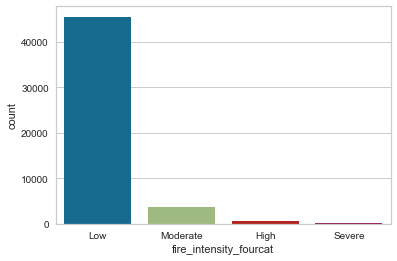

In [8]:
sns.countplot(df_fires['fire_intensity_fourcat'],label="Count")
plt.show()

### Inspect the dataframe

In [9]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

# review datagram
print (df_fires.shape)
df_fires.head(3)

(50000, 16)


,doy,fire_region,season,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat
383372,327,2,2,1,241.489287,4,67.80,0.56,0.0,9.997000,9.33,16.930000,Severe,Moderate,Low,Low
1233312,54,2,3,1,209.824992,2,83.14,0.67,0.0,9.997000,5.81,8.760000,High,Moderate,Low,Low
374521,296,0,2,1160,7020.760516,2,54.47,0.40,0.0,9.216293,3.71,11.681998,Low,Moderate,Low,Low


### Draw box diagram to see scale and quartiles of data
We have scaling issues with 1-2 values that are on a large scale.
We will address when we down select and fine tune the models with scaling. 


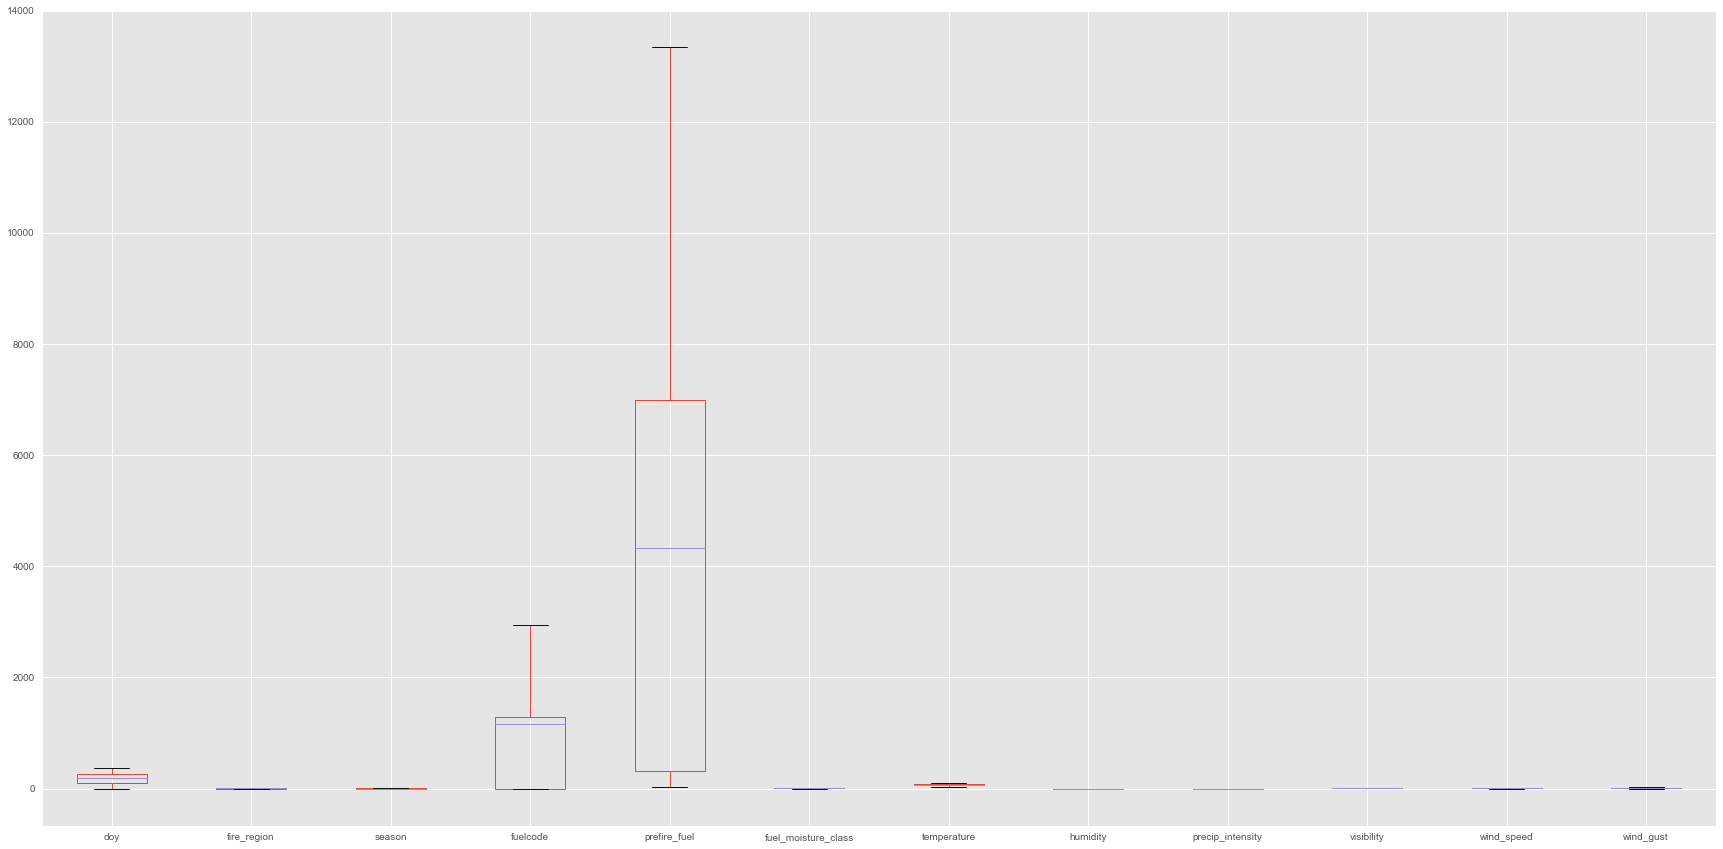

In [10]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
df_fires.plot(kind='box',figsize=(30,15))


### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
Not much else can be gleamed. 

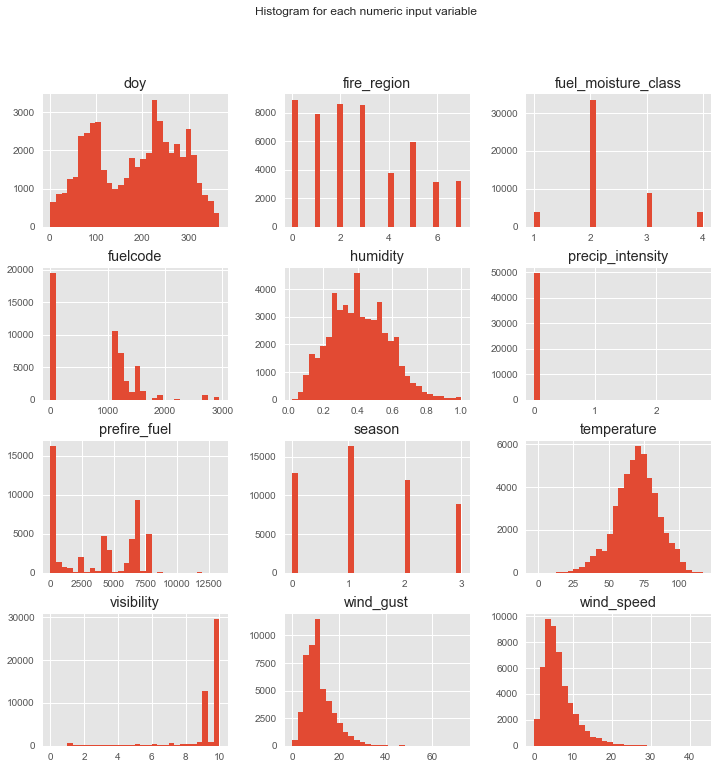

In [11]:
#historgram of all numerical data
df_fires.hist(bins=30, figsize=(12,12))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

### Fit X, y for deeper feature evaluation

In [12]:
#feature we will go with
''' 
feature_names = [ 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust']
'''

#check out model with not weather data
feature_names = ['fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class']

''' 
#remove negative values from fire temperature to help with certain models
# very few values here, in the final model code a scaler will be used
ind = 0

for ind in df_fires['temperature'].index:      
        if df_fires['temperature'][ind] < 0:
            df_fires['temperature'][ind] = 0
'''

X = df_fires[feature_names]
y = df_fires['fire_intensity_fourcat']
y = LabelEncoder().fit_transform(y)

In [13]:
### We have very unbalance bins - let's use SMOTE generate artifical data

In [14]:
#SMOTE
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(X.shape)


(182292, 5)


### Visualize the multicolinearity of features
This model is fairly good, wind or windgust can be considered for removing but may keep 
as we believe both play a hugh role in wildfires

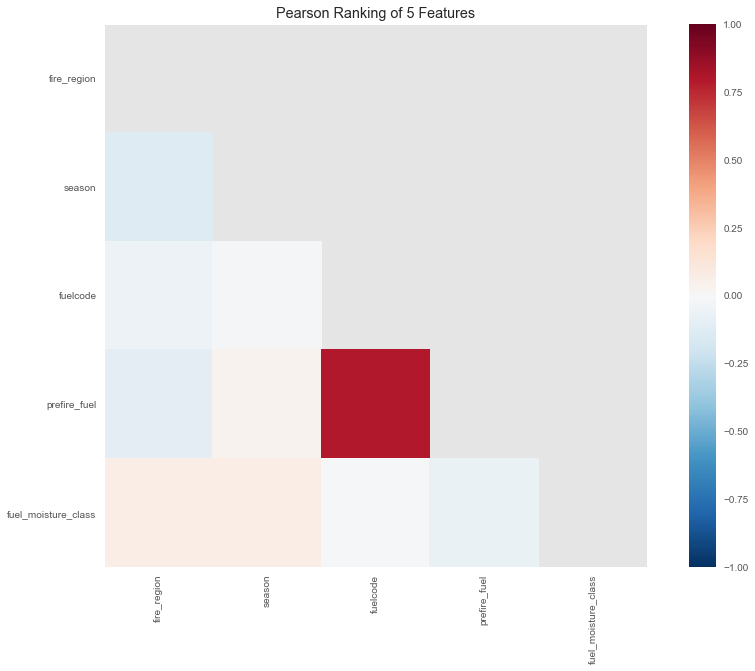

In [15]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

### Show which features likely have the most impact in RadViz
Slight skew toward wind gust but data is not completely clear

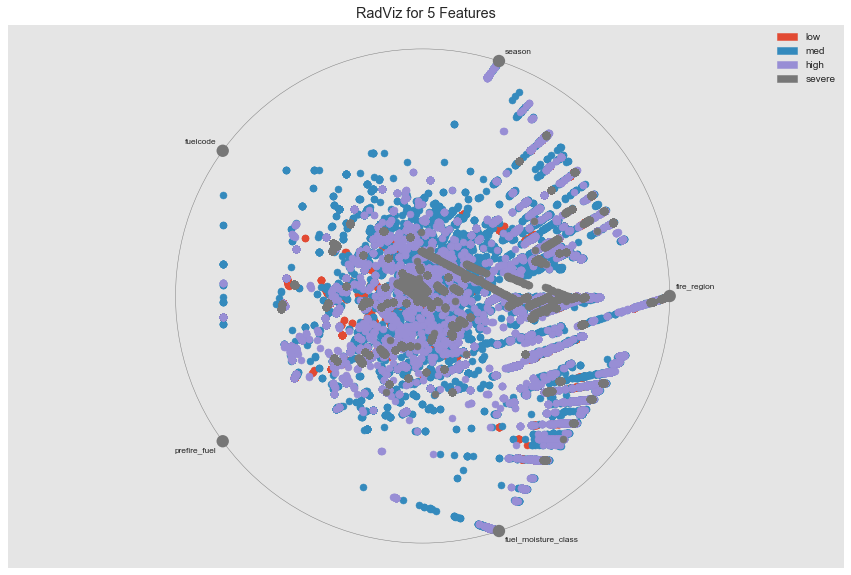

In [16]:
# Specify the target classes
classes = ["low", "med", "high", "severe"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i>  Answers differ on run but Top and bottom half are consistent though. Run 3-4 times to get a feel </i>

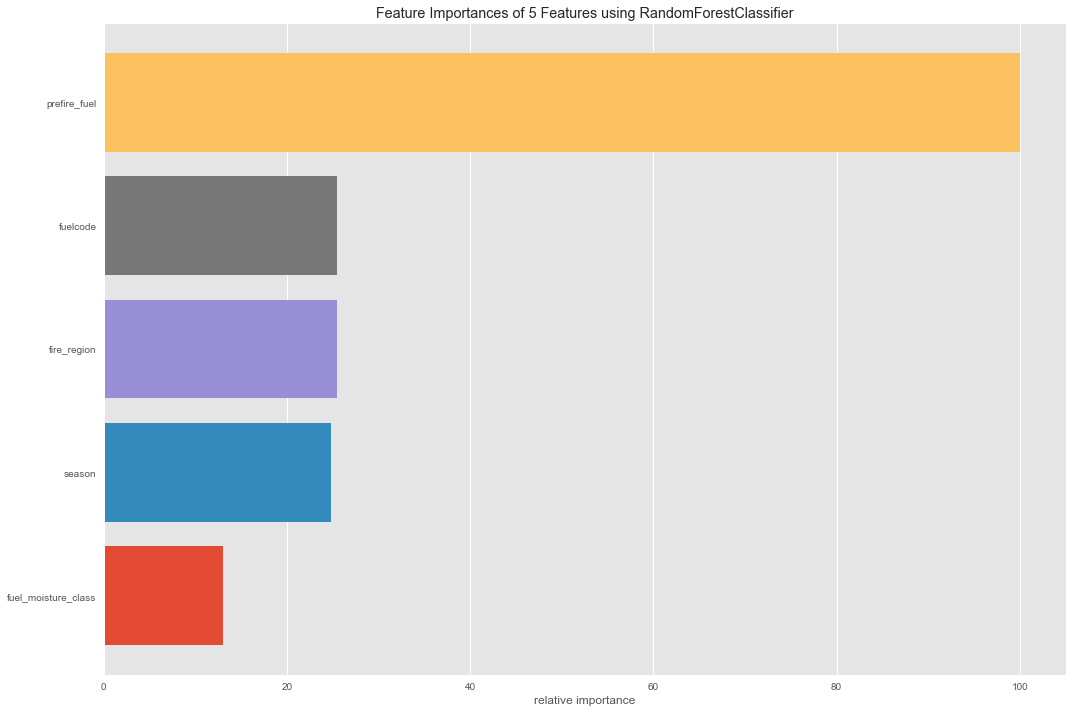

In [17]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=20)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Let's Check the learning Curve on different models
First setup the intial variable

In [18]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)


### Instantiate Multi NB
Not a great F1 score

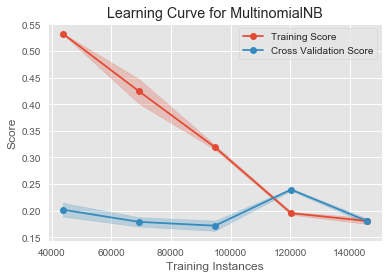

In [19]:
# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Instantiate Multi SVC
Not a great F1 score 
Warning takes a while to run.

In [20]:
# Instantiate the classification model and visualizer
#Only run if you have time

"""
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

"""

"\nmodel = LinearSVC()\nvisualizer = LearningCurve(\n    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4\n)\n\nvisualizer.fit(X, y)        # Fit the data to the visualizer\nvisualizer.show()           # Finalize and render the figure\n\n"

### Instantiate Bagging Classifier
Good F1 score - worth fine tuning data and hyper parameters

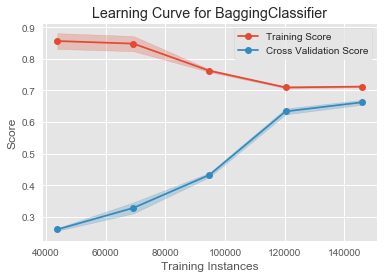

In [21]:

model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

     

#### Instantiate ExtraTrees
Good F1 score - worth fine tuning data and hyper parameters 

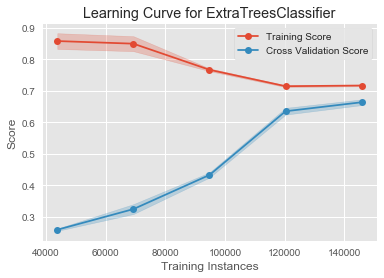

In [22]:
# Instantiate the classification model and visualizer
model = ExtraTreesClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

  

### Instantiate Random ForestClassifier
Good F1 score - worth fine tuning data and hyper parameters

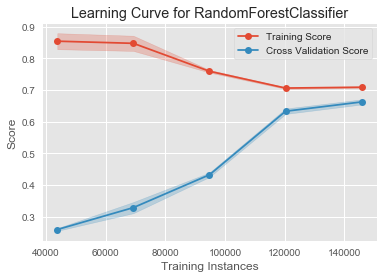

In [23]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


### Instantiate AdaBoostClassifier

Not a great F1 score 

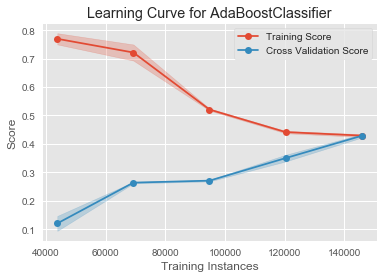

In [24]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## Final recommendation for further investigation in model tuning notebook

Features: [ 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust']
    
    
Models: Bagging, ExtraTrees, RandomForest